In [98]:
import pandas as pd
import numpy as np
import calendar
import datetime
from ast import literal_eval
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report

In [99]:
df = pd.read_json('logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [100]:
df['count'] = 1
df = df.set_index('login_time')
df.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [101]:
fdf = df.groupby(pd.Grouper(freq='15min')).aggregate(np.sum)
fdf['count'] = fdf['count'].fillna(0)
fdf.head(10)

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
1970-01-01 21:15:00,4
1970-01-01 21:30:00,0
1970-01-01 21:45:00,4
1970-01-01 22:00:00,9


In [102]:
fdf['timestamp'] = pd.to_datetime(fdf.index)

In [103]:
fdf['month'] = fdf['timestamp'].apply(lambda x: calendar.month_name[x.month])
fdf['day'] = fdf['timestamp'].apply(lambda x: calendar.day_name[x.weekday()])
fdf['hour'] = fdf['timestamp'].apply(lambda x: x.hour)
fdf['time'] = fdf['timestamp'].apply(lambda x: x.time())
fdf.head()

,count,timestamp,month,day,hour,time
login_time,,,,,,
1970-01-01 20:00:00,2,1970-01-01 20:00:00,January,Thursday,20,20:00:00
1970-01-01 20:15:00,6,1970-01-01 20:15:00,January,Thursday,20,20:15:00
1970-01-01 20:30:00,9,1970-01-01 20:30:00,January,Thursday,20,20:30:00
1970-01-01 20:45:00,7,1970-01-01 20:45:00,January,Thursday,20,20:45:00
1970-01-01 21:00:00,1,1970-01-01 21:00:00,January,Thursday,21,21:00:00


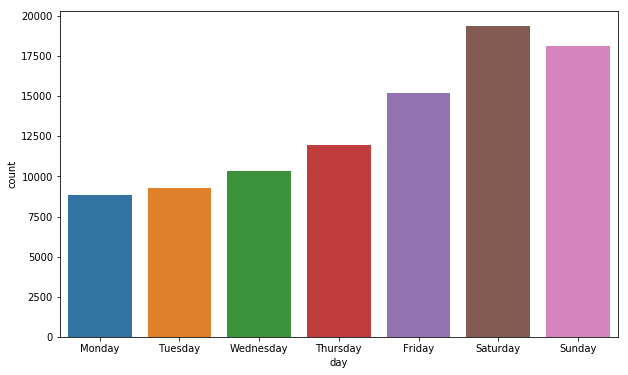

In [104]:
plt.figure(figsize=(10,6))

day_counts = fdf.groupby('day')['count'].sum()
day_counts
sns.barplot(x=day_counts.index, y = day_counts, order = calendar.day_name)

Most customer tend to login the product on Saturdays. 

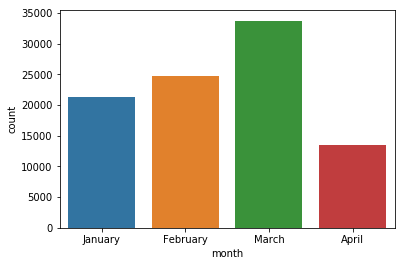

In [105]:
month_counts = fdf.groupby('month')['count'].sum()
month_counts
sns.barplot(x=month_counts.index, y = month_counts, order = ['January','February','March','April'])

Most customers tend to login the product in March

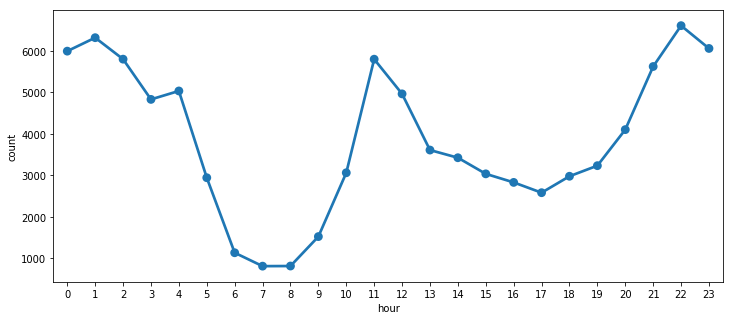

In [106]:
plt.figure(figsize=(12,5))

hour_counts = fdf.groupby('hour')['count'].sum()
sns.pointplot(x = hour_counts.index, y = hour_counts)

Most customers tend to login the product at 1 am, 11 am, and 22pm in a day. 

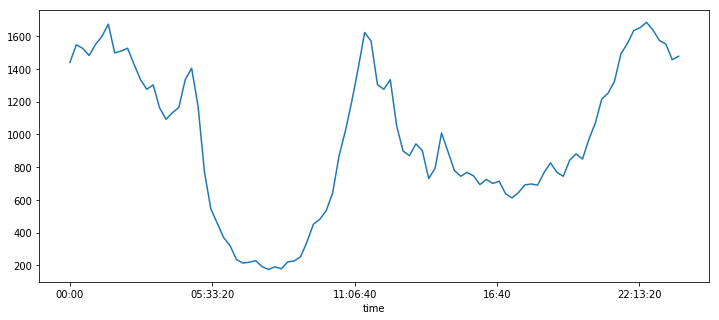

In [107]:
plt.figure(figsize=(12,5))

time_counts = fdf.groupby('time')['count'].sum()

time_counts.plot()

We plot it based on 15-minute time intervals but there is no significant differnece if comparing with the graph based on each hour in a day. 

Part 2: Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
how you will implement the experiment.
what statistical test(s) you will conduct to verify the significance of the observation.
how you would interpret the results and provide recommendations to the city operations team along with any caveats.


Solution: 

metric = |A - B| / (A + B )

For the key measure, we will have "A" to stand for the total rides a driver has in Gotham for a whole weekdays, and "B" to stand for the total rides a driver has in Metropolis for a whole weekdays as well. We have the absolute value of the difference between the two divided by the total rides a driver has through out the weekdays as our metric, which is shown above.

If the metric is closer to "0", it means that after the implemented change has succeeded, the amounts of rides between the two cities are about the same, most of drivers like to drive between the two cities. However, if the metric is closer to "1", it means that the change is not successful because most drivers have their rides only in one city.

Based on the null hypothesis that implemented change has no significant influence to the metric, we use a t-test to compare the average metric during the weekdays before and after the change was implemented. If the average metric after the change becomes smaller, and the p-value is less than 5%, it means that the null hypothesis is rejected, because there is a siginificant influence to the metric. In other words, the implemented change has successully motiveted drivers to drive through two cities. However, if the p-value is greater than 5%, it means that the null hypothesis is accepeted that the impletemented change has no significant influence to the metric.

Having drivers drive in both cities is not the only factor that may bring more profits for two cities. Hence, while encouraging drivers to drive in both cities by reimbursing all toll costs, the cities have to compare their budget and the change in revenue to see whether the implemented change does boost the net profit overall. 



In [108]:
#df2 = pd.read_json('ultimate_data_challenge.json')
data = open('ultimate_data_challenge.json', 'r').readline()
data = json.loads(data)
df2 = pd.DataFrame(data)
df2.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [109]:
df2.isnull().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
dtype: int64

In [110]:
np.mean(df2.avg_rating_by_driver)

4.778158195947439

In [111]:
np.mean(df2.avg_rating_of_driver)

4.6015592912744685

In [112]:
df2.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [113]:
df2.avg_rating_by_driver = df2.avg_rating_by_driver.fillna(np.mean(df2.avg_rating_by_driver))
df2.avg_rating_of_driver = df2.avg_rating_of_driver.fillna(np.mean(df2.avg_rating_of_driver))
df2.phone = df2.phone.fillna('iPhone')

In [114]:
df2.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [115]:
df2.last_trip_date.sort_values(ascending=False).head(10)

45357    2014-07-01
22735    2014-07-01
14473    2014-07-01
38651    2014-07-01
45126    2014-07-01
14419    2014-07-01
38661    2014-07-01
45143    2014-07-01
45154    2014-07-01
45155    2014-07-01
Name: last_trip_date, dtype: object

Given the last record date is July 1st, we have June 1st the earliest date a user can be retained.

In [140]:
df2['retained'] = df2.last_trip_date.apply(lambda x : 1 if x >= '2014-06-01' else 0)
fraction = len(df2[df2.retained.values == 1])/len(df2)
print("The retained observed user consists of", fraction, "of all the users")

The retained observed user consists of 0.37608 of all the users


In [117]:
df2.ultimate_black_user = df2.ultimate_black_user.astype('int')
df2.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,1,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,0,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,0,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,1,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,0,82.4,0


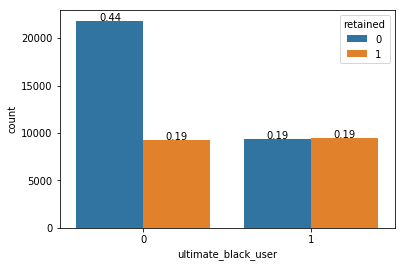

In [118]:
ax = sns.countplot(x='ultimate_black_user', hue = 'retained', data = df2)
total = float(len(df2))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 

Based on the graph, we can see that utimiate black users are more likely to retain. 

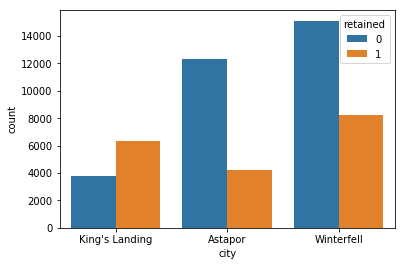

In [119]:
sns.countplot(x='city', hue = 'retained', data=df2)

Based on the graph, we can see that customers from King's Landing are most likely to retain. 

In [120]:
from sklearn import metrics

def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))


In [121]:
def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
labels=level_labels)) 

    print(cm_frame)     

In [122]:
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
labels=classes) 
    print(report)

In [123]:
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
classes=classes)

In [124]:
X, y = df2.drop(['avg_surge','signup_date', 'last_trip_date','retained','phone','city'], axis=1), df2.retained

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.30)

In [126]:
# gradient boosting
clf_gb = GradientBoostingClassifier()
clf_gb.fit(X_train, y_train)
y_pred = clf_gb.predict(X_test)


In [127]:
print ('Accuracy on training set: {}'.format(clf_gb.score(X_train, y_train)))
print ('Accuracy on testing set:  {}'.format(clf_gb.score(X_test, y_test)))

Accuracy on training set: 0.7579714285714285
Accuracy on testing set:  0.7454


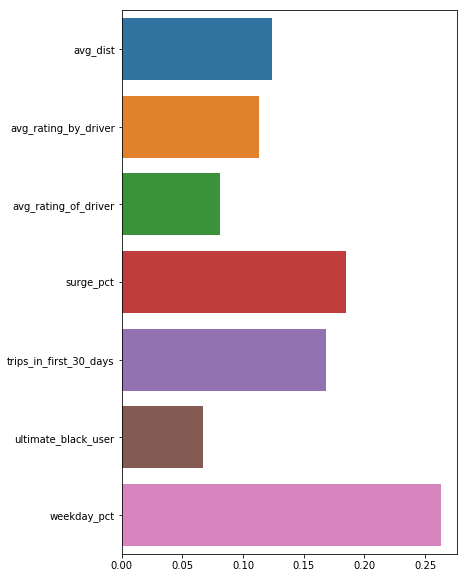

In [128]:
plt.figure(figsize=(6,10))
sns.barplot(y=X.columns, x=clf_gb.feature_importances_)

In [129]:
display_model_performance_metrics(true_labels= y_test, predicted_labels= y_pred, 
                                      classes=[0,1])

Model Performance metrics:
------------------------------
Accuracy: 0.7454
Precision: 0.7412
Recall: 0.7454
F1 Score: 0.738

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          0       0.76      0.86      0.81      9304
          1       0.71      0.56      0.62      5696

avg / total       0.74      0.75      0.74     15000


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       8000  1304
        1       2515  3181


We perform gradient boosting because this model works well with classification. Also, instead of running the data as a whole, this model divides feature sets into bags, and train each bag of features beased on the preceding overrall system for multiple times until the model satisfy.

The model's accuracy on testing set is 75% which indicates that this model performs pretty well. Since gradient boosing trains each feature in specific, based on the bar grah above, we can see that the "weekday_pct" has the most significat influence on the retained ratio. Hence, we suggest Ultimate to launch certain types of promotion deals for users who like to login on weekdays.

Even though the model performs well in this case, there might be an overfitting issue because of the fact that Gradient Boosting’ training is based on last training result. In order to fix this issue, Random Forests can be a good alternative because while running all features in a dataset, this model randomly selects a subset of features for each step and run each one independently. 
